In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import os
import sys
from glob import glob
from multiprocessing import Pool
import tempfile
import shutil
import imageio
from PIL import Image
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [10]:
def make_figure(ncols=1, center=(0, 0)):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(5 * ncols, 5), subplot_kw={'projection': ccrs.Orthographic(*center)}, squeeze=False, gridspec_kw={'wspace': 0})

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.5)
        ax.set_global()
        #ax.set_extent([-100, 30, 0, 80], crs=ccrs.PlateCarree())
    return fig, axes[0, :]

def make_figure_flat(ncols=1):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6 * ncols, 6), subplot_kw={'projection': ccrs.Mollweide()}, gridspec_kw={'wspace': 0}, squeeze=False)

    for ax in axes.flat:
        # generate a basemap with country borders, oceans and coastlines
        ax.add_feature(cfeat.LAND, color='0.6')
        #ax.add_feature(cfeat.OCEAN, color='0.4')
        ax.add_feature(cfeat.COASTLINE, lw=.7)
        ax.add_feature(cfeat.BORDERS, linestyle='dotted', lw=0.3)
        ax.set_global()
        ax.set_extent([-120, 150, -58, 90], crs=ccrs.PlateCarree())
        ax.spines['geo'].set_visible(False)
        ax.patch.set_visible(False)
    return fig, axes[0, :]

def plot_t(ds_t, vmin, vmax, title, save_dir=None, dpi=200, cmap='BrBG', levels=None, rotate=0, globe=True, t=False, is_hourly=True, **kwargs):

    if isinstance(ds_t, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(title, str):
            raise TypeError('`cmap` must be a string.')
        ds_t = [ds_t]
        vmin = [vmin]
        vmax = [vmax]
        title = [title]
        cmap = [cmap]
    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

    extends = []
    vmins = []
    vmaxs = []

    for mn, mx in zip(vmin, vmax):
        if isinstance(mn, str):
            if isinstance(mx, str):
                extends.append('both')
            else:
                extends.append('min')
        else:
            if isinstance(mx, str):
                extends.append('max')
            else:
                extends.append('neither')
            
        vmins.append(float(mn))
        vmaxs.append(float(mx))


    num_ds = len(ds_t)

    if globe:
        fig, axes = make_figure(num_ds, center=(rotate % 360, 0))
    else:
        fig, axes = make_figure_flat(num_ds)

    for i, ax in enumerate(axes):

        if levels is None:
            img = ds_t[i].plot.imshow(
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap[i],
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )
        else:
            img = ds_t[i].plot.contourf(
                levels=levels,
                ax=ax,
                transform=ccrs.PlateCarree(),
                add_colorbar=True,
                vmin=vmins[i],
                vmax=vmaxs[i],
                cmap=cmap,
                cbar_kwargs=dict(
                    orientation='horizontal', pad=0.0, shrink=0.5, label='', aspect=60, extend=extends[i]
                ),
                **kwargs
            )

        if is_hourly:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d-%H").item()
        else:
            time = ds_t[i].time.dt.strftime("%Y-%m-%d").item()

        if globe:
            cbax = inset_axes(ax,
                        width="100%",  # width = 50% of parent_bbox width
                        height="100%",  # height : 5%
                        loc='lower center',
                        bbox_to_anchor=(0.28, 0.12, 0.45, 0.02) if globe else (0.32, 0.0, 0.5, 0.02),
                        bbox_transform=ax.transAxes)
            img.colorbar.remove()         
            cbar = fig.colorbar(img, cax=cbax, orientation='horizontal', extend=extends[i])
            cbar.ax.set_title(f'{title[i]} – {time}', size=11)
            cbar.ax.tick_params(labelsize=11)
        else:
            img.colorbar.ax.set_title(f'{title[i]} – {time}', size=11, pad=0)
            img.colorbar.ax.tick_params(labelsize=11)

        #cbar.ax.xaxis.set_tick_params(color='w')
        #cbar.outline.set_edgecolor('w')
        #plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')

        ax.set_title('')
        #ax.text(0.3, 0.3, f'{title} – {time}', transform=ax.transAxes, color='w')

    # fig.tight_layout()

    if save_dir is None:
        return img
    else:
        if i is None:
            path = os.path.join(save_dir, f'frame_{time}.png')
        else:
            path = os.path.join(save_dir, f'frame_{t:05d}.png')

        fig.savefig(path, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close(fig)
        del ds_t, img, ax, title

def animate(
        ds, vmin, vmax, title, save_path, timerange=-1, levels=None,
        globe=True, rotate_speed=0, dpi=150, cmap='BrBG', fps=15, ncpus=1, use_pil=False,
        png_out=False):

    tmpdir = tempfile.mkdtemp(dir=os.path.dirname(save_path))

    if isinstance(ds, xr.Dataset):
        raise TypeError('must pass an xr.DataArray, not an xr.Dataset.')
    elif isinstance(ds, xr.DataArray):
        if not isinstance(vmin, (int, float, str)):
            raise TypeError('`vmin` must be numeric or a string.')
        if not isinstance(vmax, (int, float, str)):
            raise TypeError('`vmax` must be numeric or a string.')
        if not isinstance(title, str):
            raise TypeError('`title` must be a string.')
        if not isinstance(cmap, str):
            raise TypeError('`cmap` must be a string.')

        ntime = len(ds.time)

    else:
        if not isinstance(vmin, list):
            raise TypeError('`vmin` must be a list as multiple datasets were passed.')
        if not isinstance(vmax, list):
            raise TypeError('`vmax` must be a list as multiple datasets were passed.')
        if not isinstance(title, list):
            raise TypeError('`title` must be a list as multiple datasets were passed.')
        if not isinstance(cmap, list):
            raise TypeError('`cmap` must be a list as multiple datasets were passed.')

        ntime = len(ds[0].time)

    if timerange == -1:
        timerange = range(ntime)
    elif isinstance(timerange, int):
        timerange = range(timerange)

    if isinstance(ds, list):
        timedim = ds[0]['time']
    else:
        timedim = ds['time']

    is_hourly = xr.infer_freq(timedim) == 'H'

    try:

        par_kwargs = [{
            'ds_t': ds.isel(time=t) if isinstance(ds, xr.DataArray) else [ds[i].isel(time=t) for i in range(len(ds))],
            'vmin': vmin,
            'vmax': vmax,
            'title': title,
            'save_dir': tmpdir,
            'dpi': dpi,
            'cmap': cmap,
            'levels': levels,
            'rotate': t * rotate_speed,
            'globe': globe,
            't': t,
            'is_hourly': is_hourly
        } for t in timerange]

        par_args = [list(el.values()) for el in par_kwargs]

        # parcall(plot_t, ds_args, dry_run=False, num_cpus=ncpus, vmin=vmin, vmax=vmax, levels=levels,
        #     globe=globe, save_dir=tmpdir, title=title, cmap=cmap, dpi=dpi);

        with Pool(processes=min(len(par_args), ncpus)) as pool:
            pool.starmap(plot_t, par_args)

        fp_in = os.path.join(tmpdir, 'frame*.png')
        paths = sorted(glob(fp_in))

        if not png_out:
            #command = f'convert -delay {100 / fps} -loop 0 {fp_in} {save_path}'
            command = f'ffmpeg -y -threads 16 -framerate {fps} -pattern_type glob -i \'{fp_in}\' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p {save_path}/{title}.webm'
            print(command)
            os.system(command)
            print('Done.')

        else:
            if os.path.isdir(save_path):
                shutil.rmtree(save_path)
            os.rename(tmpdir, save_path)

    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

        


In [11]:
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr/')
ds

,Array,Chunk
Bytes,45.29 GiB,39.06 kiB
Shape,"(7305, 1140, 1460)","(100, 10, 10)"
Count,1231657 Tasks,1231656 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.06 TiB,0.92 MiB
Shape,"(24, 7305, 1140, 1460)","(24, 100, 10, 10)"
Count,1231657 Tasks,1231656 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [13]:
animate(ds.fvc.sel(time='2005').load(), vmin=0, vmax=1, title='FVC', save_path='../visualization/anim/', timerange=365, ncpus=40, png_out=False)

ffmpeg -y -threads 16 -framerate 15 -pattern_type glob -i '../visualization/anim/tmpzcpvujqu/frame*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p ../visualization/anim//FVC.webm


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 10.4.0 (conda-forge gcc 10.4.0-16)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1664280367634/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

Done.


frame=  365 fps=2.4 q=35.0 Lsize=    1008kB time=00:00:24.26 bitrate= 340.2kbits/s speed=0.16x    
video:977kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.216996%


In [18]:
ds_miss = ds.fvc.sel(time=slice('2003', '2006')).isnull().all(('lat', 'lon')).compute()

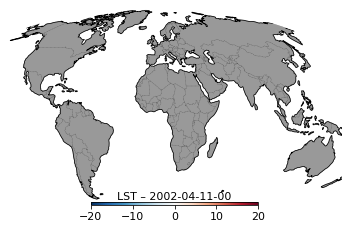

In [8]:
plot_t(ds.lst.isel(time=100, hour=7), vmin=-20, vmax=20, title='LST', cmap='RdBu_r', globe=True)

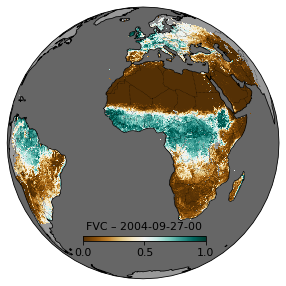

In [11]:
plot_t(ds.fvc.isel(time=700), 0, 1, 'FVC', globe=True)

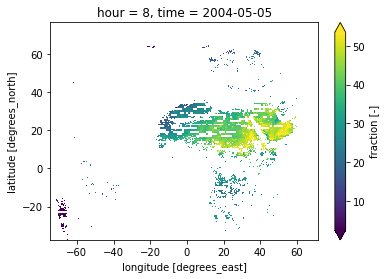

In [20]:
ds.lst.sel(time='2004-05-05', hour=8).plot(robust=True)

In [43]:
ds_ = xr.open_dataset('/Net/Groups/BGI/scratch/bkraft/drought_data/preproc/tp.hourly.1460.1140.05.2004.nc').rename({'latitude': 'lat', 'longitude': 'lon'})
ds_

<xarray.Dataset>
Dimensions:  (time: 744, lon: 1460, lat: 1140)
Coordinates:
  * time     (time) datetime64[ns] 2004-05-01 ... 2004-05-31T23:00:00
  * lon      (lon) float32 -74.5 -74.4 -74.3 -74.2 -74.1 ... 71.1 71.2 71.3 71.4
  * lat      (lat) float32 76.5 76.4 76.3 76.2 76.1 ... -37.1 -37.2 -37.3 -37.4
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Oct 13 09:52:04 2022: cdo -O -s remap,preprocessing/gri...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    min_val:      0.0
    max_val:      0.4185318648815155

In [44]:
ds_s = ds.tp.sel(time='2004-05-05T', hour=8)

In [45]:
ds__s = ds_.tp.sel(time='2004-05-05T08')

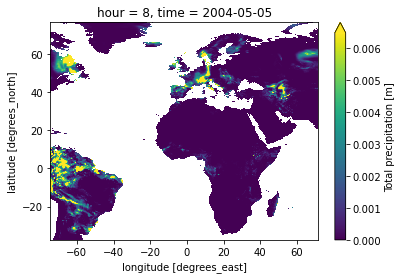

In [50]:
ds_s.plot(robust=True)

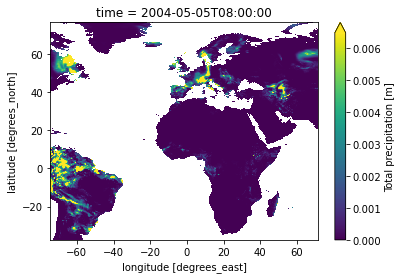

In [51]:
ds__s.plot(robust=True)

In [48]:
dff = (ds_s - ds__s).compute()

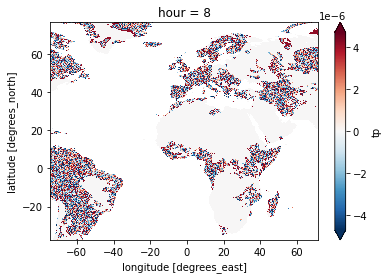

In [49]:
dff.plot(robust=True)